In [1]:
import cv2
import imghdr
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

2023-02-08 18:10:25.501537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = '/Users/giacomorossi/Desktop/progetti/Neural Network/Happy/foto'
images_exts = ['jpeg', 'jpg', 'bmp', 'png']

#preprocess of images on the fly
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1336 files belonging to 2 classes.


2023-02-08 18:10:52.422109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in images_exts:
                print('image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)

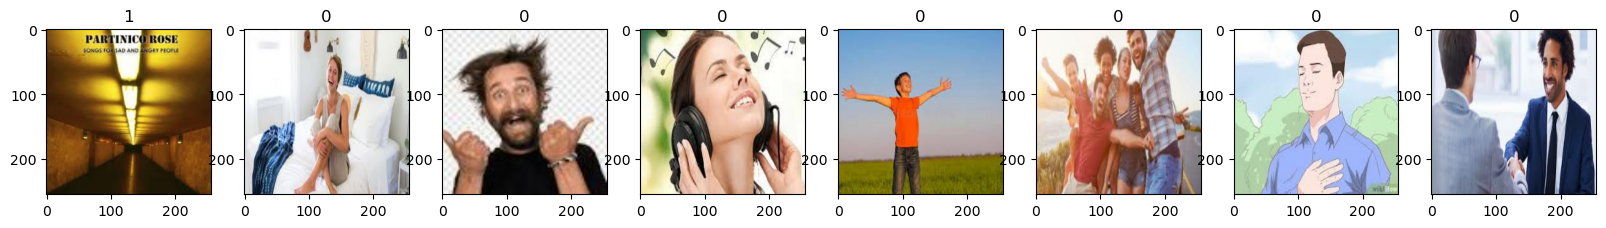

In [3]:
#creates batches
#class 1 -> sad
#class 0 -> happy
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols = 8, figsize = (20, 20))
for idx, img in enumerate(batch[0][:8]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


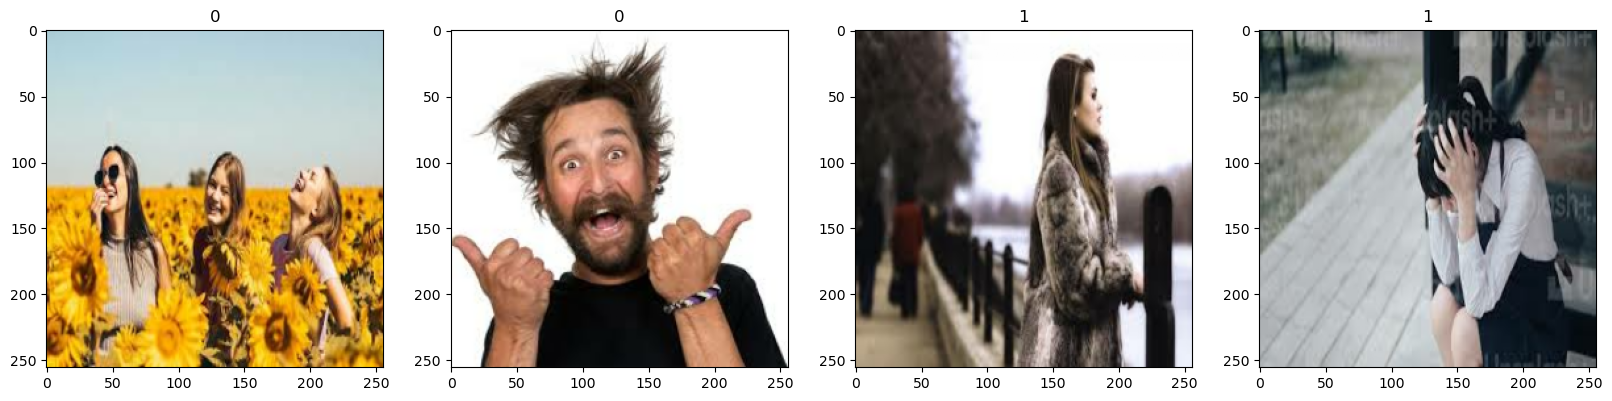

In [4]:
data_s = data.map(lambda x, y: (x/255, y))
scaled_iterator = data_s.as_numpy_iterator()
batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [5]:
len(data_s)*32 #batch size

train_size = int(len(data_s)*.7)
val_size = int(len(data_s)*.15)
test_size = int(len(data_s)*.15)
train = data_s.take(train_size)
val = data_s.skip(val_size)
test = data_s.skip(train_size*val_size).take(test_size)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [7]:
model = Sequential()

#input layer corresponding to the shape of the images
#it has 16 filters to scan the images with the filter size of (3, 3) px.
#it as a stride of 1, it moves 1px per time
model.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D()) #reduces the images looking at the max value of the size taken (2x2 by default -> halfs the images)

model.add(Conv2D(32, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #brings all in one channel

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer

print(model.summary())

model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
hist = model.fit(train, epochs = 20, validation_data = val)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [10]:
model.save('HappyImageClass')

INFO:tensorflow:Assets written to: HappyImageClass/assets


INFO:tensorflow:Assets written to: HappyImageClass/assets


In [11]:
model = tf.keras.models.load_model('/Users/giacomorossi/Desktop/progetti/Neural Network/Happy/HappyImageClass')

1/1 [==============================] - 0s 229ms/step
sad person


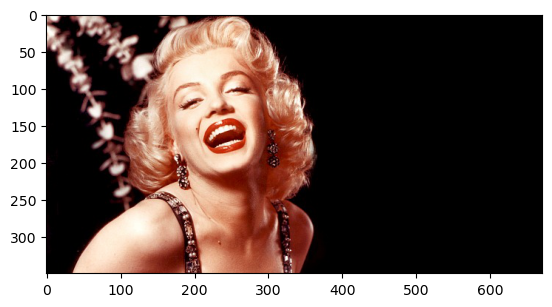

In [13]:
img = cv2.imread('/Users/giacomorossi/Desktop/progetti/Neural Network/Happy/b650-ok-omb-bb.png')
resize = tf.image.resize(img, (256, 256))

yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat.round() == 1:
  print('sad person')
else: 
  print('happy person')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()